# UC2 - Multinomial classification on Crime Description
### Tiancheng Zhang

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime

### Overview
- Available scikit-learn packages: https://scikit-learn.org/stable/modules/multiclass.html
- Target variable: Description
- Predictors: Inside/Outside, Weapon, Neighborhood, Premise, Month, Hour.



In [2]:
bpd_df = pd.read_csv('BPD_CRIME_DATA_CLEAN.csv')
bpd_df.head(10)

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Season,Month,Hour
0,2017-09-02,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,Inside,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,summer,9,23
1,2017-09-02,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,Outside,NONE,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,summer,9,23
2,2017-09-02,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",STREET,1,summer,9,22
3,2017-09-02,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,Inside,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,summer,9,22
4,2017-09-02,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,Outside,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,summer,9,22
5,2017-09-02,22:00:00,5A,CHERRYCREST RD,BURGLARY,Inside,NONE,922.0,SOUTHERN,Cherry Hill,-76.62131,39.24867,"(39.2486700000, -76.6213100000)",ROW/TOWNHO,1,summer,9,22
6,2017-09-02,21:15:00,1F,3400 HARMONY CT,HOMICIDE,Outside,FIREARM,232.0,SOUTHEASTERN,Canton,-76.56827,39.28202,"(39.2820200000, -76.5682700000)",STREET,1,summer,9,21
7,2017-09-02,21:35:00,3B,400 W LANVALE ST,ROBBERY - STREET,Outside,NONE,123.0,CENTRAL,Upton,-76.62789,39.30254,"(39.3025400000, -76.6278900000)",STREET,1,summer,9,21
8,2017-09-02,21:00:00,4C,2300 LYNDHURST AVE,AGG. ASSAULT,Outside,OTHER,641.0,NORTHWESTERN,Windsor Hills,-76.68365,39.31370,"(39.3137000000, -76.6836500000)",STREET,1,summer,9,21
9,2017-09-02,21:00:00,4E,1200 N ELLWOOD AVE,COMMON ASSAULT,Inside,HANDS,332.0,EASTERN,Berea,-76.57419,39.30551,"(39.3055100000, -76.5741900000)",ROW/TOWNHO,1,summer,9,21


In [3]:
bpd_df.Description.value_counts()

LARCENY                 60528
COMMON ASSAULT          45518
BURGLARY                42538
LARCENY FROM AUTO       36295
AGG. ASSAULT            27513
AUTO THEFT              26838
ROBBERY - STREET        17691
ROBBERY - COMMERCIAL     4141
ASSAULT BY THREAT        3503
SHOOTING                 2910
ROBBERY - RESIDENCE      2866
RAPE                     1637
HOMICIDE                 1559
ROBBERY - CARJACKING     1528
ARSON                    1464
Name: Description, dtype: int64

In [4]:
#description and weapon are correlated!
#all shooting are with firearm
bpd_df[bpd_df.Description == 'SHOOTING']['Weapon'].value_counts()

FIREARM    2910
Name: Weapon, dtype: int64

In [5]:
#but not all crimes with firearms are SHOOTING
#so Weapon is still a valid predictor
bpd_df[bpd_df.Weapon == 'FIREARM']['Description'].value_counts()

ROBBERY - STREET        7934
AGG. ASSAULT            5711
SHOOTING                2910
ROBBERY - COMMERCIAL    2444
HOMICIDE                1304
ROBBERY - CARJACKING    1056
ROBBERY - RESIDENCE      953
Name: Description, dtype: int64

/Users/tuliprichard/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


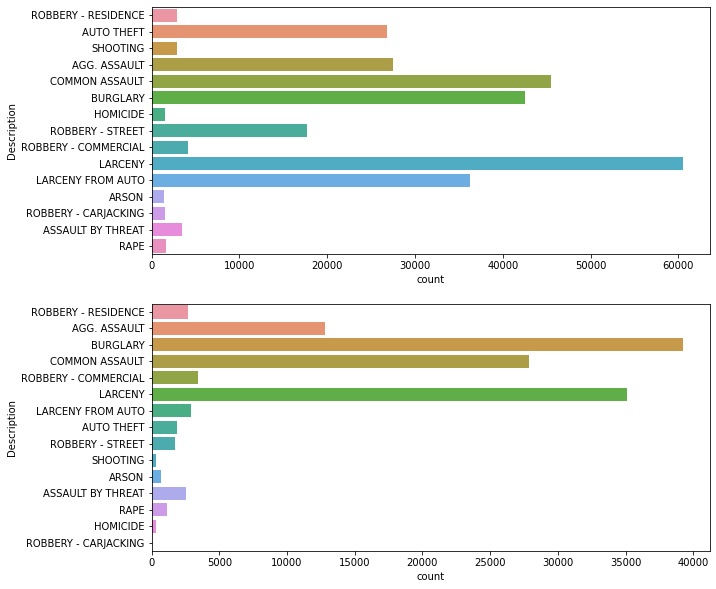

In [6]:
inside = bpd_df[bpd_df['Inside/Outside'] == 'Inside']

fig, ax = plt.subplots(2,1)
sns.countplot(y = bpd_df['Description'], ax = ax[0])
sns.countplot(y = inside['Description'], ax = ax[1])
fig.set_size_inches(10,10)
fig.show()

We do notice correlation between descriptions and Inside/Outside such as AUTO-THEFT and LANCERY FROM AUTO. But overall it's still a valid and important predictor.

### Data Preparation

In [7]:
uc2_df = bpd_df[['Inside/Outside', 'Weapon', 'Neighborhood', 'Premise', 'Month', 'Hour','Description']]

In [8]:
uc2_df = pd.get_dummies(uc2_df, columns = ['Inside/Outside', 'Weapon', 'Neighborhood', 'Premise', 'Month', 'Hour'])

In [9]:
# from sklearn.preprocessing import OneHotEncoder

# cat_encoder = OneHotEncoder()
# X_train_cat_1hot = cat_encoder.fit_transform(X_train_cat)
# X_train_cat_1hot

In [10]:
uc2_df.shape

(276529, 442)

In [11]:
X = uc2_df.drop(columns = ['Description'])
Y = uc2_df['Description']

### sklearn.multiclass - OneVsRestClassifier

The one-vs-rest strategy, also known as one-vs-all, is implemented in OneVsRestClassifier. The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed), one advantage of this approach is its interpretability. Since each class is represented by one and only one classifier, it is possible to gain knowledge about the class by inspecting its corresponding classifier. This is the most commonly used strategy and is a fair default choice.

#### LinearSVC (Multiclass as One-Vs-The-Rest)

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

In [13]:
LinearSVC_OVR = OneVsRestClassifier(LinearSVC(random_state=42069))

In [14]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(LinearSVC_OVR, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.37988094219210206

#### GradientBoostingClassifier (Multiclass as One-Vs-The-Rest)

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

In [16]:
GB_CLF = GradientBoostingClassifier()

In [17]:
# scores = cross_val_score(GB_CLF, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
# np.mean(scores)

Taking forever to run. So I'll leave it to Marek.

#### GaussianProcessClassifier (setting multi_class = “one_vs_rest”)

In [54]:
from sklearn.gaussian_process import GaussianProcessClassifier

In [55]:
GP_CLF = GaussianProcessClassifier(random_state=42069, multi_class='one_vs_rest', n_jobs=-1)

In [ ]:
#kernel = 1.0 * RBF(1.0)
# scores = cross_val_score(GP_CLF, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
# np.mean(scores)

After crashing my computer 2 times... Gave up

#### PassiveAggressiveClassifier

In [20]:
from sklearn.linear_model import PassiveAggressiveClassifier

In [21]:
PA_CLF = PassiveAggressiveClassifier(random_state = 42069, n_jobs = -1)

In [22]:
scores = cross_val_score(PA_CLF, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.32170887467463927

#### sklearn.linear_model.Perceptron

In [23]:
from sklearn.linear_model import Perceptron

In [24]:
Perc = Perceptron(random_state = 42069, n_jobs = -1)

In [25]:
scores = cross_val_score(Perc, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.33467419703182044

#### sklearn.linear_model.SGDClassifier

In [26]:
from sklearn.linear_model import SGDClassifier

In [27]:
SGDC_CLF = SGDClassifier(random_state = 42069, n_jobs = -1)

In [28]:
scores = cross_val_score(SGDC_CLF, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.36959335764571094

## inherently multiclass

In [29]:
from sklearn.naive_bayes import BernoulliNB

In [30]:
NBB = BernoulliNB()

In [31]:
scores = cross_val_score(NBB, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.4086207926955268

In [32]:
from sklearn.model_selection import GridSearchCV

In [33]:
parameters = {'alpha':[0.1 * i for i in range(11)]}
#Additive (Laplace/Lidstone) smoothing parameter (0 for no smoothing).

In [39]:
NBB_GSCV = GridSearchCV(NBB, parameters, scoring='f1_macro', n_jobs = -1)
NBB_GSCV.fit(X,Y)

GridSearchCV(estimator=BernoulliNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5,
                                   0.6000000000000001, 0.7000000000000001, 0.8,
                                   0.9, 1.0]},
             scoring='f1_macro')

In [40]:
NBB_GSCV.best_score_

0.4130233086995429

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [42]:
LDA = LinearDiscriminantAnalysis()

In [43]:
scores = cross_val_score(LDA, X, Y, cv=5, scoring='f1_macro',n_jobs=-1)
np.mean(scores)

0.3813541250546903

### Built-in Multiclass

#### linear_model.RidgeClassifierCV

In [19]:
from sklearn.linear_model import RidgeClassifierCV

In [43]:
RidgeCLF = OneVsRestClassifier(RidgeClassifierCV(alphas = [0.1,0.5,1,10], cv=None,scoring='f1_macro',store_cv_values = True))

In [44]:
# clf2.fit(X, Y)

OneVsRestClassifier(estimator=RidgeClassifierCV(alphas=array([ 0.1,  0.5,  1. , 10. ]),
                                                scoring='f1_macro',
                                                store_cv_values=True))

In [46]:
# clf2.alpha_

AttributeError: 'OneVsRestClassifier' object has no attribute 'alpha_'

In [ ]:
# clf2.best_score_

### Model - OneVsOneClassifier

OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.

Since it requires to fit n_classes * (n_classes - 1) / 2 classifiers, this method is usually slower than one-vs-the-rest, due to its O(n_classes^2) complexity. However, this method may be advantageous for algorithms such as kernel algorithms which don’t scale well with n_samples. This is because each individual learning problem only involves a small subset of the data whereas, with one-vs-the-rest, the complete dataset is used n_classes times. The decision function is the result of a monotonic transformation of the one-versus-one classification.

In [81]:
from sklearn.multiclass import OneVsOneClassifier

OneVsOneClassifier = OneVsOneClassifier(LinearSVC(random_state=5))
clf2 = OneVsOneClassifier.fit(X, Y)
# clf2.predict(X)

In [82]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf2, X, Y, cv=5, scoring='f1_macro')
scores

array([0.37355751, 0.38458121, 0.39799876, 0.40021676, 0.39568538])

### Model - OutputCodeClassifier
Error-Correcting Output Code-based strategies are fairly different from one-vs-the-rest and one-vs-one. With these strategies, each class is represented in a Euclidean space, where each dimension can only be 0 or 1. Another way to put it is that each class is represented by a binary code (an array of 0 and 1). The matrix which keeps track of the location/code of each class is called the code book. The code size is the dimensionality of the aforementioned space. Intuitively, each class should be represented by a code as unique as possible and a good code book should be designed to optimize classification accuracy. In this implementation, we simply use a randomly-generated code book as advocated in 3 although more elaborate methods may be added in the future.

At fitting time, one binary classifier per bit in the code book is fitted. At prediction time, the classifiers are used to project new points in the class space and the class closest to the points is chosen.

In OutputCodeClassifier, the code_size attribute allows the user to control the number of classifiers which will be used. It is a percentage of the total number of classes.

A number between 0 and 1 will require fewer classifiers than one-vs-the-rest. In theory, log2(n_classes) / n_classes is sufficient to represent each class unambiguously. However, in practice, it may not lead to good accuracy since log2(n_classes) is much smaller than n_classes.

A number greater than 1 will require more classifiers than one-vs-the-rest. In this case, some classifiers will in theory correct for the mistakes made by other classifiers, hence the name “error-correcting”. In practice, however, this may not happen as classifier mistakes will typically be correlated. The error-correcting output codes have a similar effect to bagging.

In [ ]:
#parameter: code_size

In [84]:
from sklearn.multiclass import OutputCodeClassifier
from sklearn.svm import LinearSVC

clf3 = OutputCodeClassifier(LinearSVC(random_state=5),
                            code_size=2, random_state=5)
clf3.fit(X, Y)

OutputCodeClassifier(code_size=2, estimator=LinearSVC(random_state=5),
                     random_state=5)

In [85]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf3, X, Y, cv=5, scoring='f1_macro')
scores

array([0.30526063, 0.30308781, 0.30823036, 0.32186999, 0.31872546])

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
OneVsRestClassifier = OneVsRestClassifier(MLPClassifier(hidden_layer_sizes = 100))
                                          
# clf4 = OneVsRestClassifier.fit(X, Y)

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf3, X, Y, cv=5, scoring='f1_macro')
scores